In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

In [66]:
data = pd.read_csv("reports/BTCUSDT_1d_20220101_20220630.csv")
print(data.head(0))
data = data.loc[:,['Timestamp','High','Low','Open','Volume','Quote Asset Volume','Close']]
print(data.head(5))
print(data.Timestamp)
data = data.set_index('Timestamp')
print(data.index)
target = 'Close'

Empty DataFrame
Columns: [Timestamp, Open, High, Low, Close, Volume, Close Time, Quote Asset Volume, Number of Trades, Taker Buy Base Asset Volume, Taker Buy Quote Asset Volume, Ignore]
Index: []
       Timestamp      High       Low      Open       Volume  \
0  1640995200000  47954.63  46208.37  46216.93  19604.46325   
1  1641081600000  47990.00  46654.00  47722.66  18340.46040   
2  1641168000000  47570.00  45696.00  47286.18  27662.07710   
3  1641254400000  47557.54  45500.00  46446.10  35491.41360   
4  1641340800000  47070.00  42500.00  45832.01  51784.11857   

   Quote Asset Volume     Close  
0        9.241552e+08  47722.65  
1        8.666110e+08  47286.18  
2        1.292204e+09  46446.10  
3        1.649170e+09  45832.01  
4        2.334289e+09  43451.13  
0      1640995200000
1      1641081600000
2      1641168000000
3      1641254400000
4      1641340800000
           ...      
175    1656115200000
176    1656201600000
177    1656288000000
178    1656374400000
179    1656

In [67]:
len(data.index)

180

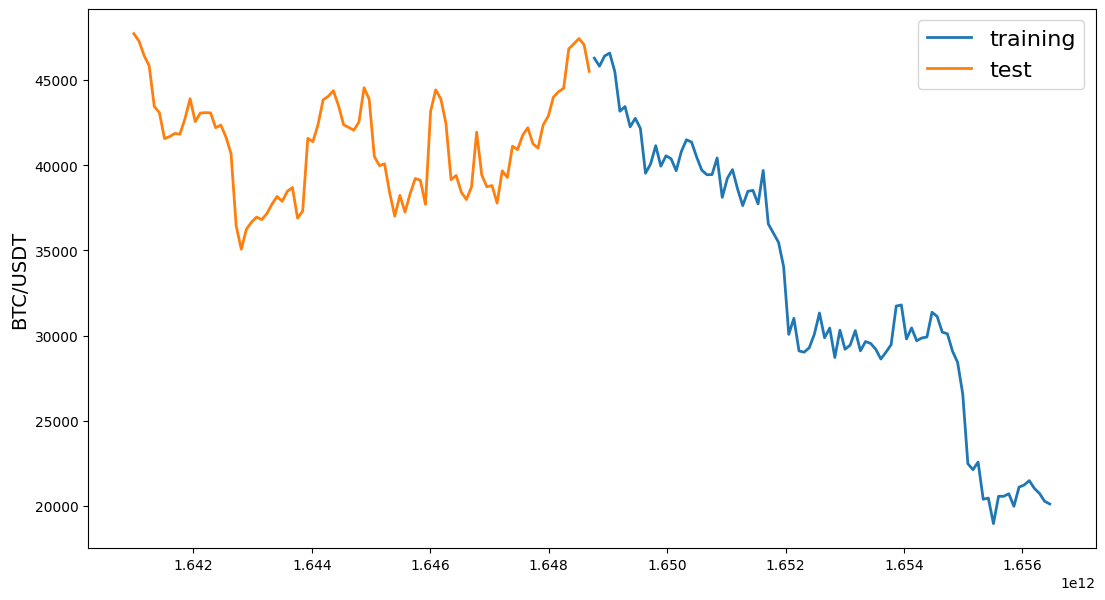

In [68]:
train_data = data.iloc[90:]
test_data = data.iloc[:90]

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('BTC/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);


line_plot(train_data[target], test_data[target], 'training', 'test', title='')

In [69]:
def normalise_zero_base(continuous):
    return continuous / continuous.iloc[0] - 1

def normalise_min_max(continuous):
    return (continuous - continuous.min()) / (data.max() - continuous.min())

def extract_window_data(continuous, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(continuous) - window_len):
        tmp = continuous[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(continuous, target, window_len=10, zero_base=True, test_size=0.2):
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target][window_len:].values
    y_test = test_data[target][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target][:-window_len].values - 1
        y_test = y_test / test_data[target][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model



In [70]:
from tensorflow.keras import layers

np.random.seed(245)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 50
epochs = 20
batch_size = 16
loss = 'mse'
dropout = 0.24
optimizer = 'adam'
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
    data, target, window_len=window_len, zero_base=zero_base, test_size=test_size)
     


In [71]:
print(np.any(np.isnan(X_test)))
print(np.any(np.isnan(y_test)))
print(X_train.shape, y_test.shape)

False
False
(85, 5, 6) (85,)


In [72]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
modelfit = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
     

Epoch 1/20
6/6 [==============================] - 1s 32ms/step - loss: 0.0198 - val_loss: 0.0083
Epoch 2/20
6/6 [==============================] - 0s 4ms/step - loss: 0.0087 - val_loss: 0.0100
Epoch 3/20
6/6 [==============================] - 0s 4ms/step - loss: 0.0109 - val_loss: 0.0079
Epoch 4/20
6/6 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0050
Epoch 5/20
6/6 [==============================] - 0s 4ms/step - loss: 0.0061 - val_loss: 0.0045
Epoch 6/20
6/6 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 7/20
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 8/20
6/6 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 9/20
6/6 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 10/20
6/6 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 11/20
6/6 [=====================

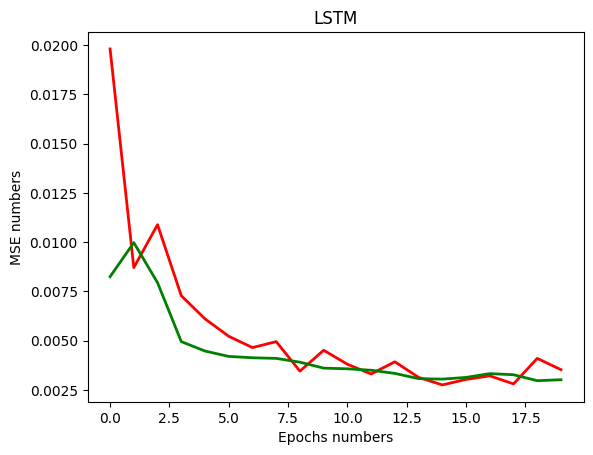

In [98]:
plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()
     

In [82]:
targets = test_data[target][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)
     

3/3 [==============================] - 0s 2ms/step


0.044329292685380356

In [85]:
from sklearn.metrics import mean_squared_error
mean_squared_error(preds, y_test)


0.00302054160952132

In [86]:
from sklearn.metrics import r2_score
r2_score=r2_score(y_test, preds)
r2_score*100

52.36934092718848

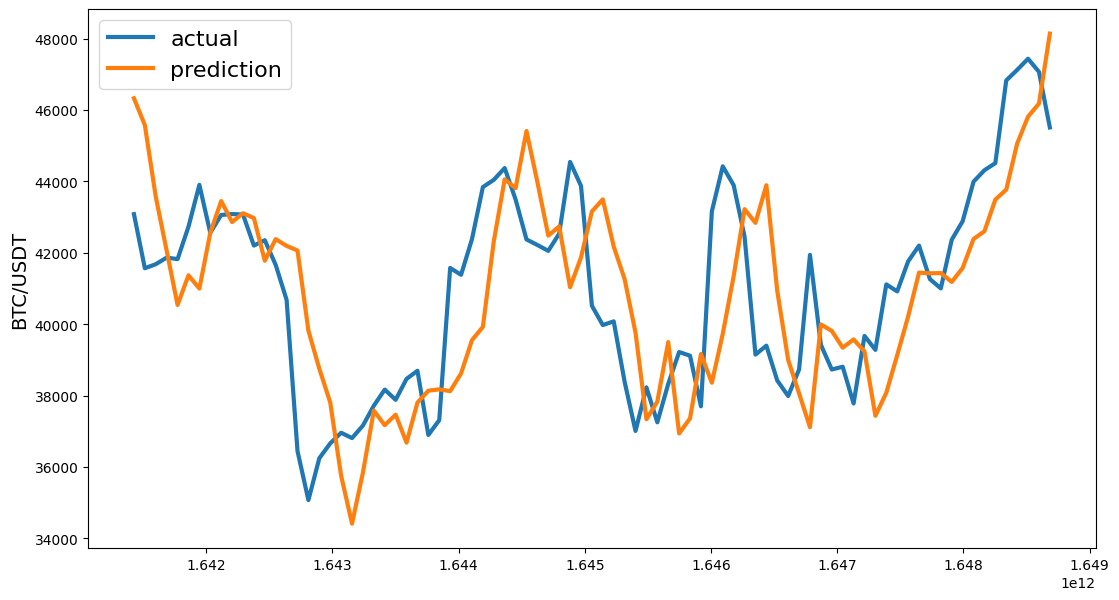

In [78]:
preds = test_data[target].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)
     

In [87]:
data = pd.read_csv("reports/BTCUSDT_1d_20220101_20230501.csv")
print(data.head(0))
data = data.loc[:,['Timestamp','High','Low','Open','Volume','Quote Asset Volume','Close']]
data = data.set_index('Timestamp')
print(data.index)
target = 'Close'

Empty DataFrame
Columns: [Timestamp, Open, High, Low, Close, Volume, Close Time, Quote Asset Volume, Number of Trades, Taker Buy Base Asset Volume, Taker Buy Quote Asset Volume, Ignore]
Index: []
Index([1640995200000, 1641081600000, 1641168000000, 1641254400000,
       1641340800000, 1641427200000, 1641513600000, 1641600000000,
       1641686400000, 1641772800000,
       ...
       1682035200000, 1682121600000, 1682208000000, 1682294400000,
       1682380800000, 1682467200000, 1682553600000, 1682640000000,
       1682726400000, 1682812800000],
      dtype='int64', name='Timestamp', length=485)


False
False
(240, 5, 6) (235,)


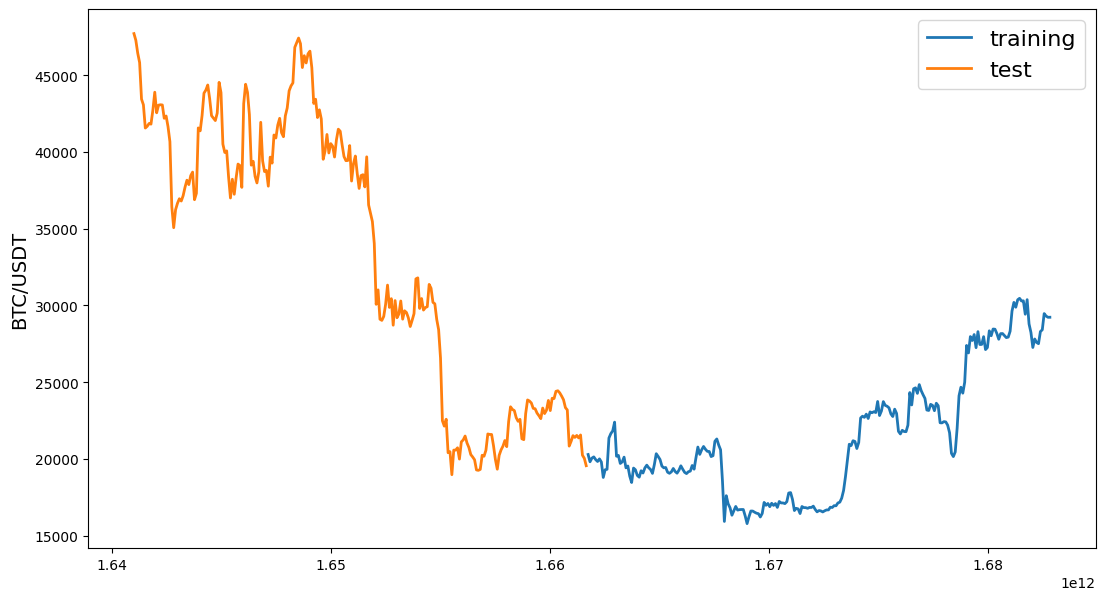

In [90]:
from tensorflow.keras import layers

train_data = data.iloc[240:]
test_data = data.iloc[:240]

line_plot(train_data[target], test_data[target], 'training', 'test', title='')

np.random.seed(245)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 50
epochs = 20
batch_size = 16
loss = 'mse'
dropout = 0.24
optimizer = 'adam'
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
    data, target, window_len=window_len, zero_base=zero_base, test_size=test_size)

print(np.any(np.isnan(X_test)))
print(np.any(np.isnan(y_test)))
print(X_train.shape, y_test.shape)

In [91]:
model_bigger_dataset = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
modelfit_bigger_dataset = model_bigger_dataset.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
     

Epoch 1/20
15/15 [==============================] - 1s 14ms/step - loss: 0.0046 - val_loss: 0.0073
Epoch 2/20
15/15 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 3/20
15/15 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 4/20
15/15 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 5/20
15/15 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 6/20
15/15 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 7/20
15/15 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 8/20
15/15 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 9/20
15/15 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 10/20
15/15 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 11/20
15/15 

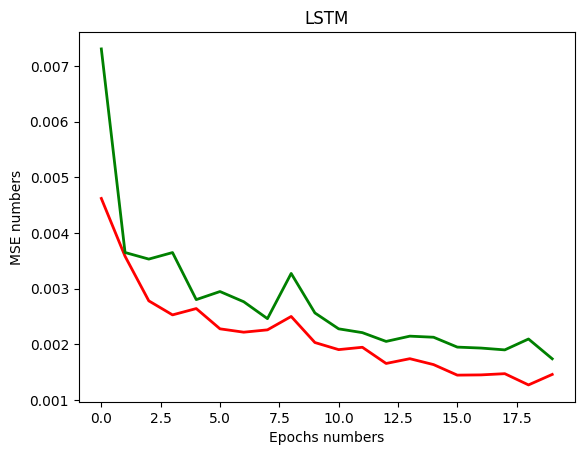

In [99]:
plt.plot(modelfit_bigger_dataset.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit_bigger_dataset.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [94]:
targets = test_data[target][window_len:]
preds = model_bigger_dataset.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

8/8 [==============================] - 0s 668us/step


0.031038872713461976

In [95]:
from sklearn.metrics import mean_squared_error
mean_squared_error(preds, y_test)

0.0017392785496585588

In [96]:
from sklearn.metrics import r2_score
r2_score=r2_score(y_test, preds)
r2_score*100

72.55901739730855

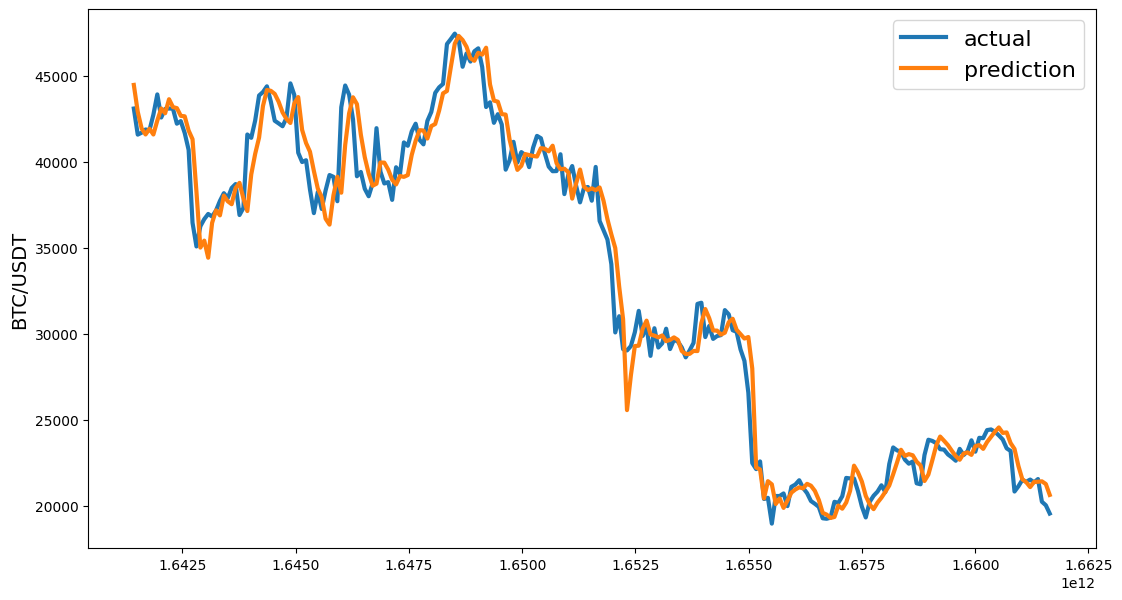

In [97]:
preds = test_data[target].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)
     